In [4]:
import numpy as np
import pandas as pd
import time
import pickle as pkl

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics

import tensorflow as tf
import keras
from keras.models import Model, Input, Sequential, load_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
import keras.backend as K
import keras.applications as KA
import keras.preprocessing as KP
from keras.utils import to_categorical
from keras.metrics import categorical_accuracy

Load data

In [5]:
with open("../assets/datasets/X_train.pkl", 'rb') as X_tr_file:
    X_train = pkl.load(X_tr_file)
with open("../assets/datasets/y_train.pkl", 'rb') as y_tr_file:
    y_train = pkl.load(y_tr_file)
with open("../assets/datasets/X_test.pkl", 'rb') as X_te_file:
    X_test = pkl.load(X_te_file)
with open("../assets/datasets/y_test.pkl", 'rb') as y_te_file:
    y_test = pkl.load(y_te_file)

labels = ["Agaricus_arvensis", "Agaricus_xanthodermus", "Amanita_muscaria", 
          "Amanita_phalloides", "Boletus_edulis", "Calocybe_gambosa",
         "Marasmius_oreades"]

In [6]:
X_train = X_train.reshape(-1,224,224,3)
X_test = X_test.reshape(-1,224,224,3)

labelencoder = LabelEncoder()
y_train_encoded = labelencoder.fit_transform(y_train)
y_test_encoded = labelencoder.transform(y_test)

y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (2958, 224, 224, 3)
y_train (2958, 7)
X_test (162, 224, 224, 3)
y_test (162, 7)


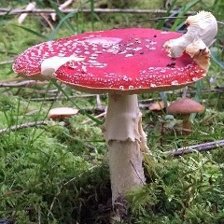

In [7]:
img0 = X_train[0]
x_4d = np.expand_dims(img0, axis=0).astype('float32')
Image.fromarray(img0)

Load model

In [5]:
####################################
# Load the model
####################################

# InceptionV3
inception_model = KA.inception_v3.InceptionV3()
preprocess = KA.inception_v3.preprocess_input
decoder = KA.inception_v3.decode_predictions

In [6]:
inception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Train a classifier with the features extracted with the network

In [7]:
extract_features_model = Model(inputs=inception_model.input,
                                 outputs=inception_model.get_layer("avg_pool").output)
features = extract_features_model.predict(preprocess(x_4d.copy()))
features.shape

(1, 2048)

In [9]:
%%time
features_train = []
train_preprocessed = []

for X in X_train:
    x_4d = np.expand_dims(X, axis=0).astype('float32')
    processed = preprocess(x_4d.copy())
    features_train.append(extract_features_model.predict(processed))
    train_preprocessed.append(processed)

features_train = np.array(features_train)
    
with open("../assets/datasets/features_inception_train.pkl", 'wb') as f:
    pkl.dump(features_train, f)
with open("../assets/datasets/train_inception_processed.pkl", 'wb') as f:
    pkl.dump(train_preprocessed, f)

CPU times: user 41min 22s, sys: 1min 14s, total: 42min 37s
Wall time: 13min 55s


In [35]:
%%time
features_test = []
test_preprocessed = []
for X in X_test:
    x_4d = np.expand_dims(X, axis=0).astype('float32')
    processed = preprocess(x_4d.copy())
    features_test.append(extract_features_model.predict(processed))
    test_preprocessed.append(processed)

features_test = np.array(features_test)
    
with open("../assets/datasets/features_inception_test.pkl", 'wb') as f:
    pkl.dump(features_test, f)
with open("../assets/datasets/test_inception_processed.pkl", 'wb') as f:
    pkl.dump(test_preprocessed, f)

CPU times: user 2min 19s, sys: 4.5 s, total: 2min 23s
Wall time: 59.9 s


In [11]:
with open("../assets/datasets/features_inception_train.pkl", 'rb') as f:
    ft_train = pkl.load(f)
    features_train = np.array(ft_train)
with open("../assets/datasets/features_inception_test.pkl", 'rb') as f:
    ft_test = pkl.load(f)
    features_test = np.array(ft_test)
with open("../assets/datasets/train_inception_processed.pkl", 'rb') as f:
    train_preprocessed = pkl.load(f)
    X_train_processed = np.array(train_preprocessed).reshape(-1, 224, 224, 3)
with open("../assets/datasets/test_inception_processed.pkl", 'rb') as f:
    test_preprocessed = pkl.load(f)
    X_test_processed = np.array(test_preprocessed).reshape(-1, 224, 224, 3)

In [22]:
a = Input(shape=(1, 2048))
x = Dense(256, activation="tanh")(a)
x = Flatten()(x)
x = Dense(100, activation="tanh")(x)
x = Dense(100, activation="tanh")(x)
x = Dense(100, activation="tanh")(x)
x = Dense(7, activation="softmax")(x)

classifier = Model(inputs=a, outputs=x)

classifier.compile(optimizer = "adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 2048)           0         
_________________________________________________________________
dense_11 (Dense)             (None, 1, 256)            524544    
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 707       
Total para

In [23]:
%%time
classifier.fit(features_train, y_train, epochs=10)

Epoch 1/10
2958/2958 [==============================] - 3s 985us/step - loss: 1.0938 - acc: 0.5727
Epoch 2/10
2958/2958 [==============================] - 2s 557us/step - loss: 0.6666 - acc: 0.7454
Epoch 3/10
2958/2958 [==============================] - 2s 549us/step - loss: 0.5022 - acc: 0.8103
Epoch 4/10
2958/2958 [==============================] - 2s 564us/step - loss: 0.4307 - acc: 0.8448
Epoch 5/10
2958/2958 [==============================] - 2s 580us/step - loss: 0.3119 - acc: 0.8857
Epoch 6/10
2958/2958 [==============================] - 2s 524us/step - loss: 0.2824 - acc: 0.9016
Epoch 7/10
2958/2958 [==============================] - 2s 550us/step - loss: 0.2157 - acc: 0.9195
Epoch 8/10
2958/2958 [==============================] - 2s 585us/step - loss: 0.1867 - acc: 0.9304
Epoch 9/10
2958/2958 [==============================] - 2s 557us/step - loss: 0.1245 - acc: 0.9547
Epoch 10/10
2958/2958 [==============================] - 2s 573us/step - loss: 0.1068 - acc: 0.9648
CPU times

In [40]:
classifier.evaluate(features_test, y_test)

162/162 [==============================] - 0s 165us/step


[0.38820940913793484, 0.8827160493827161]

In [27]:
classifier.save("../assets/models/transfer_inception_model.h5")

In [8]:
classifier_l = load_model("../assets/models/transfer_inception_model.h5")
classifier_l.evaluate(features_test, y_test)

NameError: name 'features_test' is not defined

In [8]:
a = extract_features_model.output
x = Dense(256, activation="tanh")(a)
x = Dense(100, activation="tanh")(x)
x = Dense(100, activation="tanh")(x)
x = Dense(100, activation="tanh")(x)
x = Dense(7, activation="softmax")(x)

classifier = Model(inputs=extract_features_model.input, outputs=x)

for layer in classifier.layers[:-5]:
    layer.trainable=False
for layer in classifier.layers[-5:]:
    layer.trainable=True

classifier.compile(optimizer = "adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [12]:
%%time
classifier.fit(X_train_processed, y_train, epochs=5)

Epoch 1/5
2958/2958 [==============================] - 545s 184ms/step - loss: 1.4774 - acc: 0.4114
Epoch 2/5
2958/2958 [==============================] - 541s 183ms/step - loss: 0.9222 - acc: 0.6542
Epoch 3/5
2958/2958 [==============================] - 540s 183ms/step - loss: 0.7475 - acc: 0.7184
Epoch 4/5
2958/2958 [==============================] - 537s 182ms/step - loss: 0.6536 - acc: 0.7559
Epoch 5/5
2958/2958 [==============================] - 538s 182ms/step - loss: 0.5990 - acc: 0.7823
CPU times: user 2h 32min 17s, sys: 9min 2s, total: 2h 41min 19s
Wall time: 45min 2s


In [13]:
classifier.save("../assets/models/transfer_inception_model_tfalse.h5")

In [11]:
classifier = load_model("../assets/models/transfer_inception_model.h5")

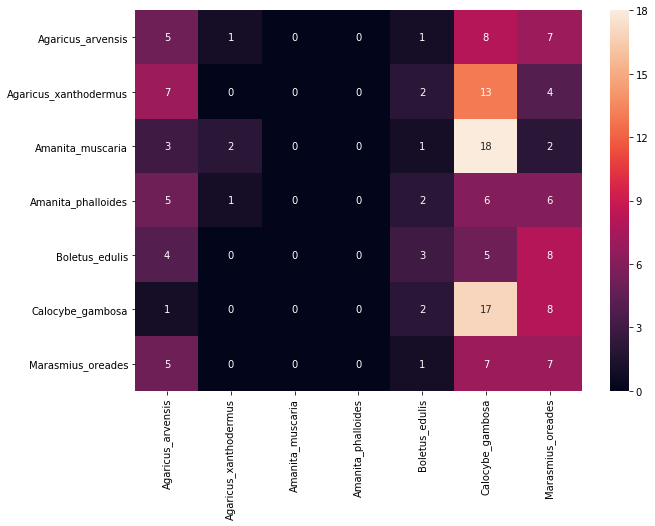

In [13]:
predicted = classifier.predict(X_test)
df_cm = pd.DataFrame(metrics.confusion_matrix(y_test.argmax(axis=1), predicted.argmax(axis=1)), index=labels,
                  columns=labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

_____________________________________________________________